In [18]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import monotonically_increasing_id, col, format_number, round, stddev, mean, expr, corr, lit, expr, format_string
import matplotlib.pyplot as plt

import seaborn as sns  # Import seaborn for density plots
from scipy import stats  # Import scipy for Q-Q plot
from pyspark.sql.types import FloatType, DoubleType, IntegerType

from pyspark.ml.feature import OneHotEncoder, StringIndexer


from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline

## SPARK SESSION

In [2]:
spark = SparkSession.builder.appName("sparkhive").enableHiveSupport().getOrCreate()

## Data Extraction from Hive

In [3]:
df = spark.sql("SELECT * FROM fraud_project.fraud_full_load_external")

In [4]:
df.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|row_id|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+------+
|  34|CASH_OUT| 15035.83| C396303562|          0.0|           0.0|C1361864867|    4551466.66|    4435198.72|      0|             0|     1|
|  34|CASH_OUT|288516.18| C535294249|          0.0|           0.0| C605769476|    3065350.68|    3315415.14|      0|             0|     2|
|  34|CASH_OUT|  57806.2| C446804712|          0.0|           0.0| C402952734|     918389.84|     976196.04|      0|             0|     3|
|  34|CASH_OUT| 154163.0|C1878410600|          0.0|           0.0| C102932163|    1986039.03|    2140202.04|      0|             0|     4|
|  34|CASH_OUT|348094.59|  

In [5]:
#Checking for null values
columns = df.columns

# Count null values for each column
null_counts_per_column = [df.where(col(c).isNull()).count() for c in columns]

# Display the null counts for each column
for col_name, null_count in zip(columns, null_counts_per_column):
    print(f"Null count in '{col_name}': {null_count}")
    

    
# # Display null values for one specific column
# null_count = filtered_df.filter(col('amount').isNull()).count()

# # Print the result
# if null_count > 0:
#     print(f"The column has null values.")
#     print(null_count)
# else:
#     print(f"The column does not have any null values.")
#     print(null_count)

Null count in 'step': 0
Null count in 'type': 0
Null count in 'amount': 0
Null count in 'nameOrig': 0
Null count in 'oldbalanceOrg': 0
Null count in 'newbalanceOrig': 0
Null count in 'nameDest': 0
Null count in 'oldbalanceDest': 0
Null count in 'newbalanceDest': 0
Null count in 'isFraud': 0
Null count in 'isFlaggedFraud': 0
Null count in 'row_id': 0


In [13]:
#Adding an incremental id to keep tranck of the transactions
#df = df.withColumn("id", monotonically_increasing_id())

In [6]:
#Selecting the features that we will be using in our model
selected_columns = ["row_id","type","amount", "oldbalanceorg", "newbalanceorig", "oldbalancedest", "newbalancedest", "isfraud"]
df_new = df.select(*selected_columns)
df_new.show()

#Dropping the columns that we won't be using
#columns_to_drop=["step", "nameOrig", "nameDest", "isFlaggedFraud", "row_id"]
#df_new=df.drop(*columns_to_drop)
#df_new.show()

+------+--------+---------+-------------+--------------+--------------+--------------+-------+
|row_id|    type|   amount|oldbalanceorg|newbalanceorig|oldbalancedest|newbalancedest|isfraud|
+------+--------+---------+-------------+--------------+--------------+--------------+-------+
|     1|CASH_OUT| 15035.83|          0.0|           0.0|    4551466.66|    4435198.72|      0|
|     2|CASH_OUT|288516.18|          0.0|           0.0|    3065350.68|    3315415.14|      0|
|     3|CASH_OUT|  57806.2|          0.0|           0.0|     918389.84|     976196.04|      0|
|     4|CASH_OUT| 154163.0|          0.0|           0.0|    1986039.03|    2140202.04|      0|
|     5|CASH_OUT|348094.59|          0.0|           0.0|    1760686.51|     2108781.1|      0|
|     6|CASH_OUT| 168081.1|          0.0|           0.0|     559033.74|     727114.83|      0|
|     7|CASH_OUT|319238.71|          0.0|           0.0|     595177.34|     914416.05|      0|
|     8|CASH_OUT|208345.23|          0.0|         

In [27]:
#Visualizing the types of each columns #1
df_new.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceorg: double (nullable = true)
 |-- newbalanceorig: double (nullable = true)
 |-- oldbalancedest: double (nullable = true)
 |-- newbalancedest: double (nullable = true)
 |-- isfraud: long (nullable = true)



In [28]:
#Name of columns, name of rows
#num_columns = len(df_new.columns)
#num_rows= df_new.count()

In [29]:
################
#Visualizing the types of each columns #2
#column_data_types = selected_df.dtypes

# Print the data types
#for column, data_type in column_data_types:
    #print(f"Column '{column}' has data type '{data_type}'")

#####################
#Filtering Values in case we need it
#Specify the value you want to filter out
#value_to_remove = "1.0E7" 
# Remove rows where the "amount" column has the specified value
#filtered_df = df_new.filter(df_new.amount != value_to_remove)

#################
#Modify the types of certain columns
# #Define the columns you want to modify
# int_column = "isfraud"
# float_columns = ["amount", "oldbalanceorg", "newbalanceorig", "oldbalancedest", "newbalancedest"]

# # Cast the "isfraud" column to IntegerType
# filtered_df = filtered_df.withColumn(int_column, col(int_column).cast(IntegerType()))

# # Cast the remaining columns to FloatType
# for column in float_columns:
#     filtered_df = filtered_df.withColumn(column, col(column).cast(FloatType()

In [30]:
# # Specify the column you want to analyze
# column_to_check = "amount"

# # Check if the specified column has values that are not float or integer and count them
# non_float_or_integer_count = df_new.filter(
#     col(column_to_check).cast("double").isNull() &
#     (col(column_to_check).cast("string") != "")
# ).count()

# # Print the result
# if non_float_or_integer_count > 0:
#     print(f"The column '{column_to_check}' has {non_float_or_integer_count} values that are not float or integer.")
# else:
#     print(f"The column '{column_to_check}' does not have any values that are not float or integer.")

In [31]:
# # Check if the specified column has values that are not float or integer and show the rows
# non_float_or_integer_rows  = filtered_df.filter(
#     col(column_to_check).cast("double").isNull() &
#     (col(column_to_check).cast("string") != "")
# )

# # Show the rows with non-float or non-integer values
# non_float_or_integer_rows.show()

In [32]:
# # Filter out the rows with non-float or non-integer values
# filtered_df = filtered_df.filter(
#     col(column_to_check).cast("double").isNotNull() |
#     (col(column_to_check).cast("string") == "")
# )

# # Check the DataFrame after removing the rows
# filtered_df.show()

## Exploratory Data Analysis (EDA)

#Statistical Analysis
#Plot some feature distributions
#Correlation Matrix

In [22]:
# Calculate summary statistics with one decimal place
summary = df_new.summary()

summary = summary.select(
    summary['summary'],
    format_string('%.1f', summary['amount'].cast('double')).alias('amount'),
    format_string('%.1f', summary['oldbalanceorg'].cast('double')).alias('oldbalanceorg'),
    format_string('%.1f', summary['newbalanceorig'].cast('double')).alias('newbalanceorig'),
    format_string('%.1f', summary['oldbalancedest'].cast('double')).alias('oldbalancedest'),
    format_string('%.1f', summary['newbalancedest'].cast('double')).alias('newbalancedest')
)

summary.show()

# # Calculate summary statistics with one decimal place #2nd way
# summary = df_new.summary()

# summary = summary.select(
#     summary['summary'],
#     #format_number(summary['transaction_type'].cast('double'), 1).alias('transaction_type'),
#     format_number(summary['amount'].cast('double'), 1).alias('amount'),
#     format_number(summary['oldbalanceorg'].cast('double'), 1).alias('oldbalanceorg'),
#     format_number(summary['newbalanceorig'].cast('double'), 1).alias('newbalanceorig'),
#     format_number(summary['oldbalancedest'].cast('double'), 1).alias('oldbalancedest'),
#     format_number(summary['newbalancedest'].cast('double'), 1).alias('newbalancedest'),
#     #format_number(summary['isfraud'].cast('double'), 1).alias('isfraud')
# )

# summary.show()

+-------+---------+-------------+--------------+--------------+--------------+
|summary|   amount|oldbalanceorg|newbalanceorig|oldbalancedest|newbalancedest|
+-------+---------+-------------+--------------+--------------+--------------+
|  count|   5000.0|       5000.0|        5000.0|        5000.0|        5000.0|
|   mean| 175702.8|     845801.4|      865365.0|     1023092.2|     1167171.3|
| stddev| 279428.1|    3361683.9|     3393366.5|     2485877.8|     2581171.6|
|    min|     23.6|          0.0|           0.0|           0.0|           0.0|
|    25%|  15484.2|          0.0|           0.0|           0.0|           0.0|
|    50%|  88781.7|      11313.0|           0.0|      130922.7|      254481.4|
|    75%| 233861.6|     103143.0|      137299.7|      918569.3|     1199213.8|
|    max|4780975.4|   28519744.9|    28591377.0|    36487842.2|    36553673.1|
+-------+---------+-------------+--------------+--------------+--------------+



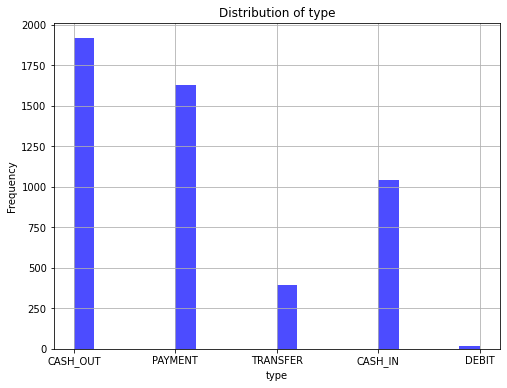

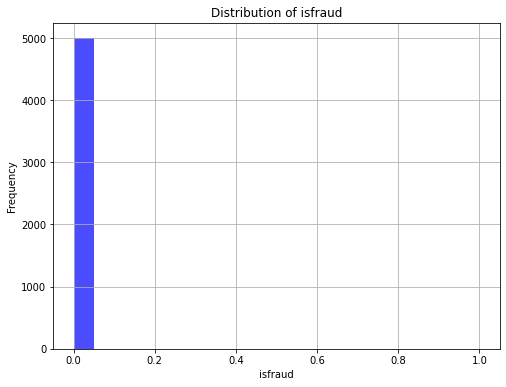

In [34]:
#Feature Distribution
# Select the columns to plot
columns_to_plot = ["type", "isfraud"]

# Create histograms for each categorical column
for column in columns_to_plot:
    # Extract the column and convert it to a Pandas DataFrame for plotting
    column_data = df_new.select(column).toPandas()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(column_data[column], bins=20, color='blue', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

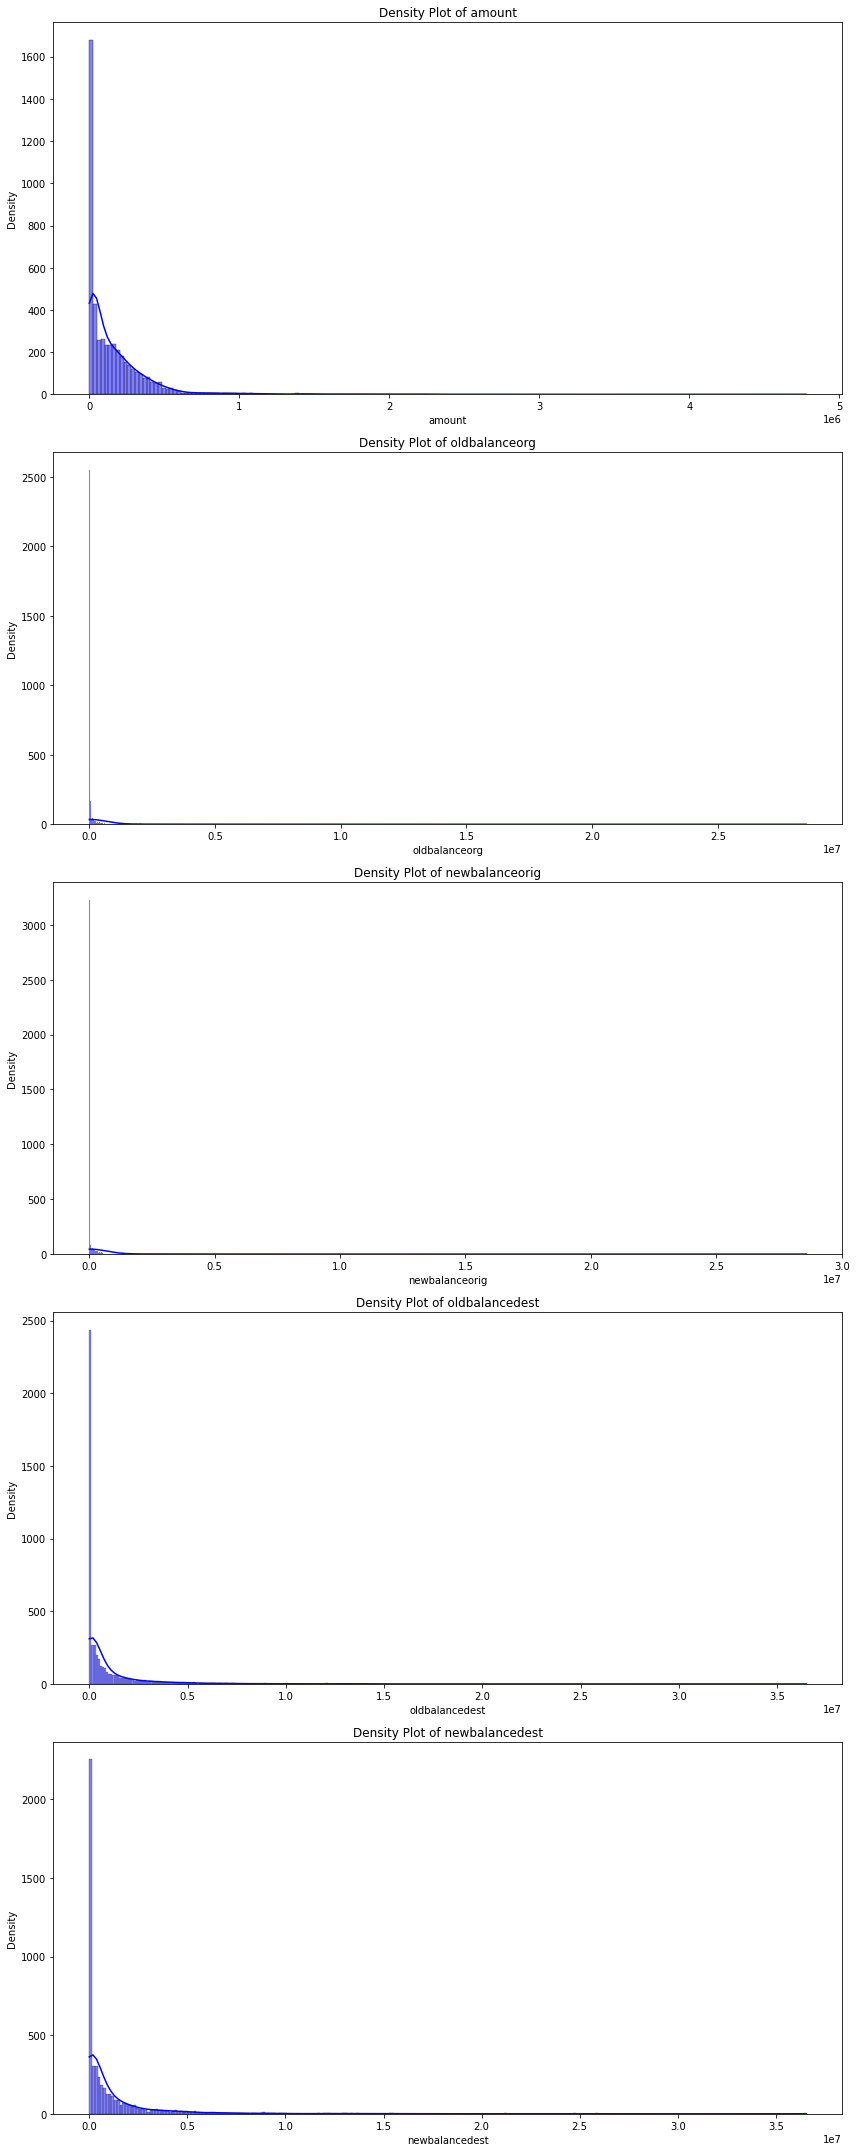

In [36]:
# Select the continuous columns to plot
continuous_columns = ["amount", "oldbalanceorg", "newbalanceorig", "oldbalancedest", "newbalancedest"]

# Create a single figure to hold all the subplots
fig, axes = plt.subplots(nrows=len(continuous_columns), ncols=1, figsize=(12, 6 * len(continuous_columns)))

# Create density plots and Q-Q plots for each continuous column
for i, column in enumerate(continuous_columns):
    # Cast the column to a numeric type (e.g., double) before plotting
    column_data = df_new.select(col(column).cast("double")).toPandas()

    # Plot the density plot
    ax = axes[i]
    sns.histplot(column_data[column], ax=ax, kde=True, color='blue')
    ax.set_title(f'Density Plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

# Adjust the layout and display all subplots together
plt.tight_layout()
plt.show()

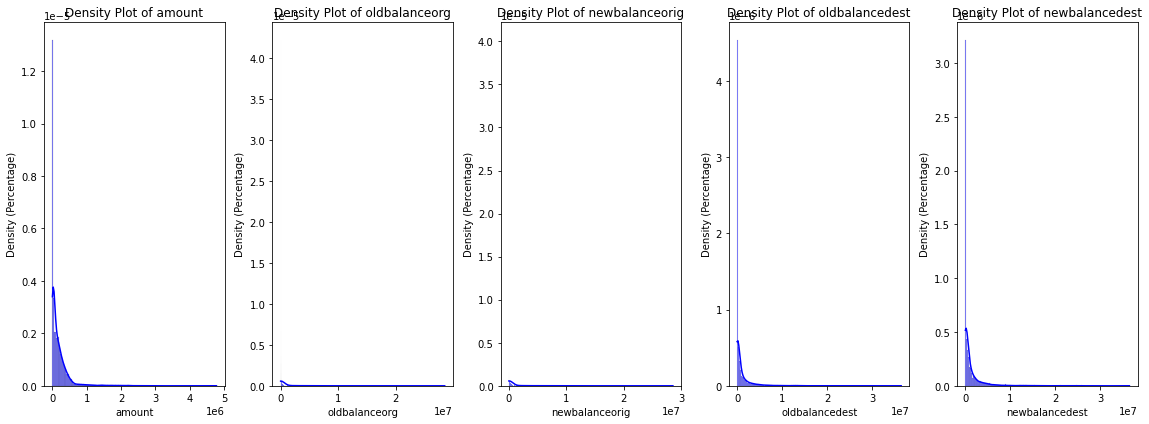

In [37]:
# Create a single figure for all the density plots
fig, axes = plt.subplots(nrows=1, ncols=len(continuous_columns), figsize=(16, 6))

# Create density plots for each continuous column
for i, column in enumerate(continuous_columns):
    # Extract the column and convert it to a Pandas DataFrame for plotting
    column_data = df_new.select(col(column).cast("double")).toPandas()

    # Create a density plot
    ax = axes[i]
    sns.histplot(column_data[column], ax=ax, kde=True, color='blue', stat='density')
    ax.set_title(f'Density Plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density (Percentage)')  # Update the y-axis label

# Adjust the layout and display all density plots together
plt.tight_layout()
plt.show()

/home/ec2-user/.local/lib/python3.6/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/ec2-user/.local/lib/python3.6/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/ec2-user/.local/lib/python3.6/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/ec2-user/.local/lib/python3.6/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/ec2-user/.local/lib/python3.6/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


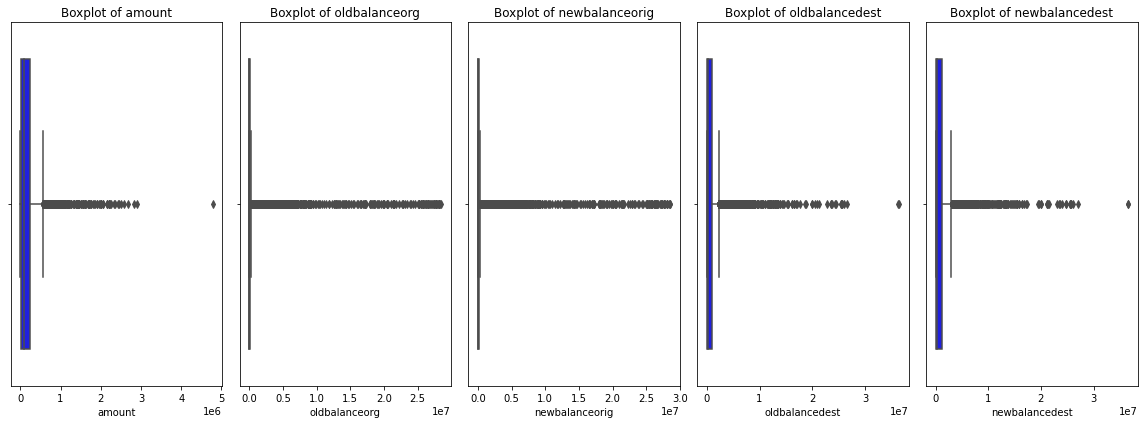

In [38]:
# Create a single figure for all the boxplots
fig, axes = plt.subplots(nrows=1, ncols=len(continuous_columns), figsize=(16, 6))

# Create boxplots for each continuous column
for i, column in enumerate(continuous_columns):
    # Extract the column and convert it to a Pandas DataFrame for plotting
    column_data = df_new.select(col(column).cast("double")).toPandas()

    # Create a boxplot
    ax = axes[i]
    sns.boxplot(x=column_data[column], ax=ax, orient="vertical", color='blue')
    ax.set_title(f'Boxplot of {column}')
    ax.set_xlabel(column)

# Adjust the layout and display all boxplots together
plt.tight_layout()
plt.show()

In [39]:
# #Correlaction Matrix

# # Select the columns for which you want to calculate the correlation
# selected_columns = ["amount", "oldbalanceorg", "newbalanceorig", "oldbalancedest", "newbalancedest", "isfraud"]

# # Ensure all selected columns are cast to FloatType (numeric type)
# numeric_columns = [col(column).cast(FloatType()).alias(column) for column in selected_columns]

# # Initialize an empty correlation matrix
# correlation_matrix = []

# # Calculate correlations between pairs of columns
# for column1 in selected_columns:
#     row = []
#     for column2 in selected_columns:
#         correlation = filtered_df.stat.corr(column1, column2)
#         row.append(correlation)
#     correlation_matrix.append(row)

# # Create a DataFrame from the correlation matrix
# correlation_df = spark.createDataFrame(correlation_matrix, selected_columns)

# # Display the correlation matrix
# correlation_df.show()

## Feature Engineering

#Null Values
#Imputation Techniques 
#Scale the data
#One Hot Encoding
#Techniques to balance the data (Oversampling and Undersampling Techniques)

In [41]:
#Applying some one hot encoding
# Define the column you want to encode
categorical_column = "type"

# Step 1: StringIndexer to convert categorical values to numerical indices
indexer = StringIndexer(inputCol=categorical_column, outputCol="categoryIndex")

# Fit and transform the indexer on your DataFrame
indexed_df = indexer.fit(df_new).transform(df_new)

# Step 2: OneHotEncoder to perform one-hot encoding
encoder = OneHotEncoder(inputCol="categoryIndex", outputCol="encoded_" + categorical_column)

# Fit and transform the encoder on your DataFrame
encoded_df = encoder.transform(indexed_df)

# Show the resulting DataFrame with one-hot encoding
encoded_df.select(categorical_column, "encoded_" + categorical_column).show()

+--------+-------------+
|    type| encoded_type|
+--------+-------------+
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
| PAYMENT|(4,[1],[1.0])|
| PAYMENT|(4,[1],[1.0])|
| PAYMENT|(4,[1],[1.0])|
| PAYMENT|(4,[1],[1.0])|
|TRANSFER|(4,[3],[1.0])|
| PAYMENT|(4,[1],[1.0])|
| PAYMENT|(4,[1],[1.0])|
| PAYMENT|(4,[1],[1.0])|
|CASH_OUT|(4,[0],[1.0])|
+--------+-------------+
only showing top 20 rows



In [42]:
# Show the entire DataFrame (adjust the number as needed)
encoded_df.show()

+------+--------+---------+-------------+--------------+--------------+--------------+-------+-------------+-------------+
|row_id|    type|   amount|oldbalanceorg|newbalanceorig|oldbalancedest|newbalancedest|isfraud|categoryIndex| encoded_type|
+------+--------+---------+-------------+--------------+--------------+--------------+-------+-------------+-------------+
|     1|CASH_OUT| 15035.83|          0.0|           0.0|    4551466.66|    4435198.72|      0|          0.0|(4,[0],[1.0])|
|     2|CASH_OUT|288516.18|          0.0|           0.0|    3065350.68|    3315415.14|      0|          0.0|(4,[0],[1.0])|
|     3|CASH_OUT|  57806.2|          0.0|           0.0|     918389.84|     976196.04|      0|          0.0|(4,[0],[1.0])|
|     4|CASH_OUT| 154163.0|          0.0|           0.0|    1986039.03|    2140202.04|      0|          0.0|(4,[0],[1.0])|
|     5|CASH_OUT|348094.59|          0.0|           0.0|    1760686.51|     2108781.1|      0|          0.0|(4,[0],[1.0])|
|     6|CASH_OUT

In [49]:
# Drop the "transaction_type" column
encoded_df = encoded_df.drop("type")
encoded_df = encoded_df.drop("categoryIndex")
encoded_df.show()

+------+---------+-------------+--------------+--------------+--------------+-------+-------------+
|row_id|   amount|oldbalanceorg|newbalanceorig|oldbalancedest|newbalancedest|isfraud| encoded_type|
+------+---------+-------------+--------------+--------------+--------------+-------+-------------+
|     1| 15035.83|          0.0|           0.0|    4551466.66|    4435198.72|      0|(4,[0],[1.0])|
|     2|288516.18|          0.0|           0.0|    3065350.68|    3315415.14|      0|(4,[0],[1.0])|
|     3|  57806.2|          0.0|           0.0|     918389.84|     976196.04|      0|(4,[0],[1.0])|
|     4| 154163.0|          0.0|           0.0|    1986039.03|    2140202.04|      0|(4,[0],[1.0])|
|     5|348094.59|          0.0|           0.0|    1760686.51|     2108781.1|      0|(4,[0],[1.0])|
|     6| 168081.1|          0.0|           0.0|     559033.74|     727114.83|      0|(4,[0],[1.0])|
|     7|319238.71|          0.0|           0.0|     595177.34|     914416.05|      0|(4,[0],[1.0])|


In [50]:
encoded_df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceorg: double (nullable = true)
 |-- newbalanceorig: double (nullable = true)
 |-- oldbalancedest: double (nullable = true)
 |-- newbalancedest: double (nullable = true)
 |-- isfraud: long (nullable = true)
 |-- encoded_type: vector (nullable = true)



In [51]:
#Check how balanced is the data
class_counts = encoded_df.groupBy("isfraud").count()

# Show the class counts
class_counts.show()

# Count the total number of samples
total_count = encoded_df.count()

# Calculate the percentage of fraud samples
fraud_percentage = (encoded_df.filter(col("isfraud") == 1).count() / total_count) * 100.0

# Calculate the percentage of non-fraud samples
non_fraud_percentage = (encoded_df.filter(col("isfraud") == 0).count() / total_count) * 100.0

# Print the percentages
print(f"Percentage of Fraud Samples: {fraud_percentage:.2f}%")
print(f"Percentage of Non-Fraud Samples: {non_fraud_percentage:.2f}%")

+-------+-----+
|isfraud|count|
+-------+-----+
|      0| 4998|
|      1|    2|
+-------+-----+

Percentage of Fraud Samples: 0.04%
Percentage of Non-Fraud Samples: 99.96%


In [ ]:
#Apply Oversampling or Undersampling Techniques 

## MODELING

#Split the dataset into training and testing
#Logistic regression, 2 Ensemble techniques (Randon Forest and XGBoost)


In [52]:
#Split the data into training and testing
# Define the feature columns (excluding the target column "isfraud")
feature_columns = [col for col in encoded_df.columns if col != "isfraud"]

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(encoded_df)

# Split the data into training and testing sets (80% for training, 20% for testing)
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [53]:
#Logistic Regression and Random Forest

# Define the models
logistic_regression = LogisticRegression(featuresCol="features", labelCol="isfraud")
random_forest = RandomForestClassifier(featuresCol="features", labelCol="isfraud")
# You can define and add XGBoost here if it's available in your PySpark environment.

# Create a list of models
models = [logistic_regression, random_forest]

In [ ]:
# # Create a list to store model evaluation results
# results = []

# # Train and evaluate each model
# for model in models:
#     # Train the model
#     model_fit = model.fit(train_df)
    
#     # Make predictions on the test data
#     predictions = model_fit.transform(test_df)
    
#     # Evaluate the model using MulticlassClassificationEvaluator
#     evaluator = MulticlassClassificationEvaluator(labelCol="isfraud", predictionCol="prediction", metricName="accuracy")
#     accuracy = evaluator.evaluate(predictions)
#     precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
#     recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    
    
#     results.append((model.__class__.__name__, accuracy, precision, recall))

In [59]:
results = []

# Train and evaluate each model
for model in models:
    # Train the model
    model_fit = model.fit(train_df)
    
    # Make predictions on the test data
    predictions = model_fit.transform(test_df)
    
    # Evaluate the model using BinaryClassificationEvaluator
    binary_evaluator = BinaryClassificationEvaluator(labelCol="isfraud")
    multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="isfraud", metricName="accuracy")
    
    # Calculate area under the ROC curve (AUC-ROC)
    auc_roc = binary_evaluator.evaluate(predictions)
    
    # Calculate accuracy
    accuracy = multiclass_evaluator.evaluate(predictions)
    
    # Calculate precision
    true_positive = predictions.filter((col("isfraud") == 1) & (col("prediction") == 1)).count()
    predicted_positive = predictions.filter(col("prediction") == 1).count()
    #precision = true_positive / predicted_positive
    
    # Calculate recall
    actual_positive = predictions.filter(col("isfraud") == 1).count()
    recall = true_positive / actual_positive
    #recall = multiclass_evaluator.evaluate(predictions)
    
    results.append((model.__class__.__name__, auc_roc, accuracy, recall))

## EVALUATION

#Accuracy
#Recall
#Precision
#F1 Score
#AUC-ROC

In [60]:
# Print the evaluation results
for model_name, auc_roc, accuracy, recall in results:
    print(f"{model_name}:")
    print(f"AUC-ROC = {auc_roc:.2f}")
    print(f"Accuracy = {accuracy:.2f}")
    #print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print()

LogisticRegression:
AUC-ROC = 0.99
Accuracy = 1.00
Recall = 0.00

RandomForestClassifier:
AUC-ROC = 1.00
Accuracy = 1.00
Recall = 0.00

